In [1]:
import pandas as pd
import numpy  as np
from scipy.misc import imresize
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models     import Sequential
from keras.layers     import Dense, Dropout, Activation, Flatten
from keras.layers     import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
import keras


from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(0)

In [3]:
TRAIN_PATH = "../../../../data/wiki_folds/gender/train_1.csv"
VALID_PATH = "../../../../data/wiki_folds/gender/valid_1.csv"
IMG_PATH  = "../../../../data/wiki/%s"

IMG_WIDTH  = 227
IMG_HEIGHT = 227
IMG_DIMS = (IMG_WIDTH, IMG_HEIGHT)

In [4]:
train = pd.read_csv(TRAIN_PATH)
valid = pd.read_csv(VALID_PATH)

train = train[["full_path","gender","age"]]
valid = valid[["full_path","gender","age"]]

In [5]:
train.head()

,full_path,gender,age
0,79/3781079_1888-02-15_1981.jpg,1.0,93
1,72/8801772_1950-11-09_2012.jpg,1.0,62
2,10/33256210_1979-04-06_2012.jpg,1.0,33
3,07/14853007_1984-05-07_2007.jpg,0.0,23
4,27/11914827_1986-05-21_2014.jpg,1.0,28


In [6]:
valid.head()

,full_path,gender,age
0,17/8740317_1961-08-29_2009.jpg,1.0,48
1,40/31819740_1984-10-18_2014.jpg,1.0,30
2,81/32702381_1929-02-17_1956.jpg,1.0,27
3,69/43906569_1930-04-24_1952.jpg,1.0,22
4,69/16116069_1942-04-20_2011.jpg,0.0,69


In [7]:
true_path = lambda x: IMG_PATH % x
train["full_path"] = train["full_path"].apply(lambda x: true_path(x))
valid["full_path"] = valid["full_path"].apply(lambda x: true_path(x))

In [8]:
def get_image(x):
    try:
        val = img_to_array(imresize(load_img(x),IMG_DIMS))
    except:
        val = "ERR"
    return val

def generate_data(df):
    while True:
        start, end = 0, 32
        data = df.sample(frac=1).reset_index(drop=True)
        sample  = data[start:end]
        temp    = sample
        
        temp["full_path"] = pd.DataFrame(sample["full_path"].apply( lambda x:get_image(x)))
        temp = temp[temp["full_path"] != "ERR"]
        temp.reset_index(inplace=True)
        
        X = temp
        X = X["full_path"].apply(lambda x: x.reshape((1,)+ x.shape))
        X = np.vstack(X)
        
        Y = temp["gender"].as_matrix()
        yield (X,Y)

In [9]:
train_generator = generate_data(train)
valid_generator = generate_data(valid)

a,b = valid_generator.next()
b

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/pandas/core/ops.py:739: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = lib.scalar_compare(x, y, op)


array([ 1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
        0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  0.,  1.,  1.,  1.])

In [10]:
# Building a vainilla CNN
vainilla_cnn = Sequential()
vainilla_cnn.add(Convolution2D(32, 3, 3, input_shape=(227,227,3), name='conv1_1'))
vainilla_cnn.add(Activation('relu'))
vainilla_cnn.add(MaxPooling2D(pool_size=(2, 2)))
vainilla_cnn.add(Convolution2D(64, 3, 3))
vainilla_cnn.add(Activation('relu'))
vainilla_cnn.add(Convolution2D(64, 3, 3))
vainilla_cnn.add(Activation('relu'))
vainilla_cnn.add(MaxPooling2D(pool_size=(2, 2)))
vainilla_cnn.add(Flatten())
vainilla_cnn.add(Dense(output_dim=200, input_dim=500))
vainilla_cnn.add(BatchNormalization())
vainilla_cnn.add(Activation("relu"))
vainilla_cnn.add(Dense(output_dim=100, input_dim=200))
vainilla_cnn.add(BatchNormalization())
vainilla_cnn.add(Activation("relu"))
vainilla_cnn.add(Dense(output_dim=1))
vainilla_cnn.add(Activation("sigmoid"))

In [11]:
# Compile
vainilla_cnn.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=0.001), metrics=['accuracy'])

In [12]:
# Train
history = vainilla_cnn.fit_generator(train_generator, 
                           validation_data=valid_generator,
                           nb_val_samples=64,
                           samples_per_epoch=64, 
                           nb_epoch=500)

Epoch 1/500


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


64/64 [==============================] - 6s - loss: 0.6263 - acc: 0.6406 - val_loss: 1.6739 - val_acc: 0.7656
Epoch 2/500
64/64 [==============================] - 1s - loss: 0.6328 - acc: 0.6875 - val_loss: 1.2972 - val_acc: 0.6875
Epoch 3/500
64/64 [==============================] - 1s - loss: 0.5732 - acc: 0.7500 - val_loss: 0.5374 - val_acc: 0.8594
Epoch 4/500
64/64 [==============================] - 1s - loss: 0.6781 - acc: 0.6719 - val_loss: 0.7339 - val_acc: 0.8125
Epoch 5/500
64/64 [==============================] - 1s - loss: 0.4439 - acc: 0.7812 - val_loss: 0.4524 - val_acc: 0.8750
Epoch 6/500
64/64 [==============================] - 1s - loss: 0.6692 - acc: 0.6250 - val_loss: 0.7408 - val_acc: 0.7969
Epoch 7/50

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


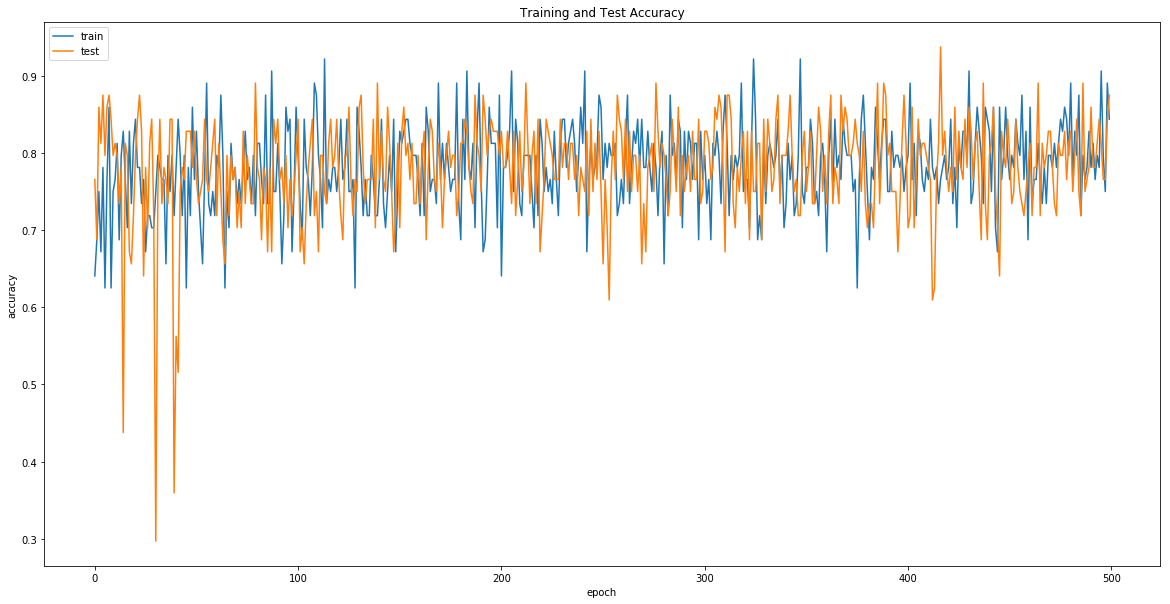

In [13]:
 # Plotting training accuracy and testing accuracy acros epochs
plt.figure(figsize=(20,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and Test Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()